In [1]:
if (!requireNamespace('BiocManager', quietly = TRUE)){
  install.packages('BiocManager')
}
if (!requireNamespace("Biobase", quietly = TRUE)) {
  install.packages("Biobase", dependencies = TRUE)
}
BiocManager::install('GEOquery')
install.packages("umap")
library(GEOquery)
library(limma)
library(umap)
library(Biobase)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GEOquery'"
Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'fontawesome', 'later',
  'progressr', 'promises', 'reticulate', 'uwot'




The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpcWrZdP/downloaded_packages


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)


Attaching package: 'limma'


The follow

# Differential Gene Expression Analysis

In [2]:
gset <- getGEO("GSE140829", GSEMatrix =TRUE, AnnotGPL=FALSE)
if (length(gset) > 1) idx <- grep("GPL15988", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

# group membership for all samples
gsms <- paste0("0X0X00000X000000100000011000X010X00101100100000000",
        "XX00X0000X1101101X0001X1010000000X011000X111111XX1",
        "01001X11X0XX11X0X010000X11X01X00XX1X00X10XX000X101",
        "XX00X000001000X011X01X1010XXX011XXX110011X01XXX101",
        "10X100001001XX110000XX110000011X00000X11101X001X1X",
        "111111X01X0010XX101111101111110111111000011001X01X",
        "0X010X101X010101X11X000X00XXX01001111X011111X110XX",
        "X1XX0X1XX1111001XXX111X1100X1X0X11X11XX011X0111X11",
        "X11110X100X1X11110X10110X000011110X0001101101X01X1",
        "00000100X1000010X0000X1101010101X00X1011100X001X0X",
        "0X0X000X00X00000010X01XX0X00X000X01X1111X1010X0110",
        "1100001X0X0X010X010011XX01X1X1000X01X")
sml <- strsplit(gsms, split="")[[1]]

Found 1 file(s)

GSE140829_series_matrix.txt.gz



In [3]:
sel <- which(sml != "X")
sml <- sml[sel]
gset <- gset[ ,sel]

In [4]:
ex <- exprs(gset)
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) ||
          (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 0)] <- NaN
  exprs(gset) <- log2(ex) }

In [5]:
gs <- factor(sml)
groups <- make.names(c("Control","AD"))
levels(gs) <- groups
gset$group <- gs
design <- model.matrix(~group + 0, gset)
colnames(design) <- levels(gs)
gset <- gset[complete.cases(exprs(gset)), ] # skip missing values
fit <- lmFit(gset, design)  # fit linear model

In [6]:
cts <- paste(groups[1], groups[2], sep="-")
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)
tT <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
write.csv(tT, file="Differential_Expression_AD.csv", row.names=T)

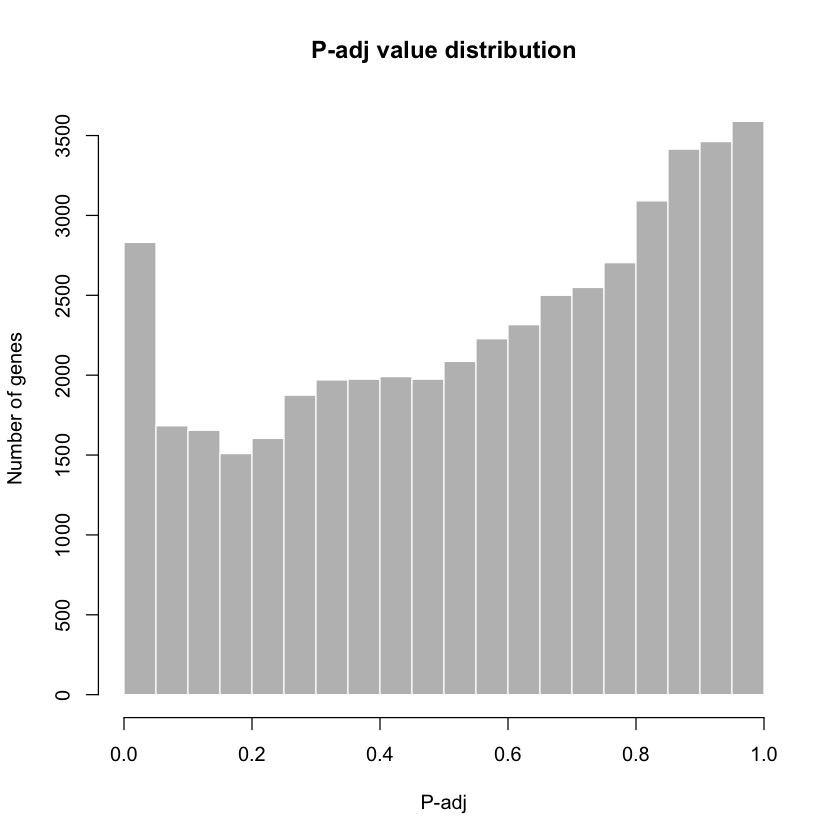

In [7]:
tT2 <- topTable(fit2, adjust="fdr", sort.by="B", number=Inf)
hist(tT2$adj.P.Val, col = "grey", border = "white", xlab = "P-adj",
  ylab = "Number of genes", main = "P-adj value distribution")

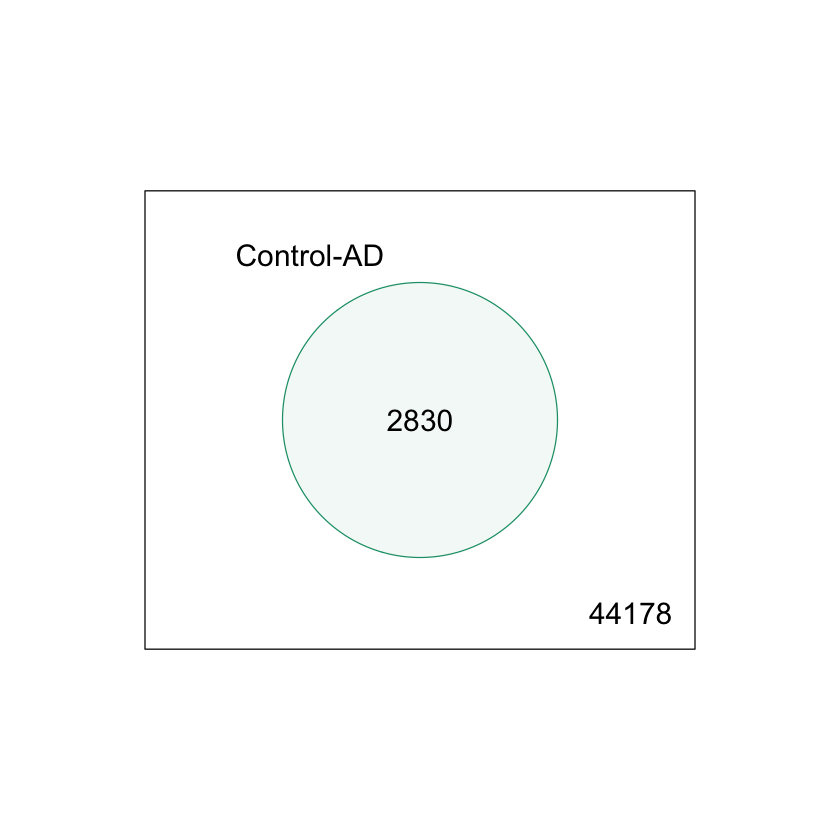

In [23]:
# summarize test results as "up", "down" or "not expressed"
dT <- decideTests(fit2, adjust.method="fdr", p.value=0.05, lfc=0.01)

# Venn diagram of results
vennDiagram(dT, circle.col=palette())

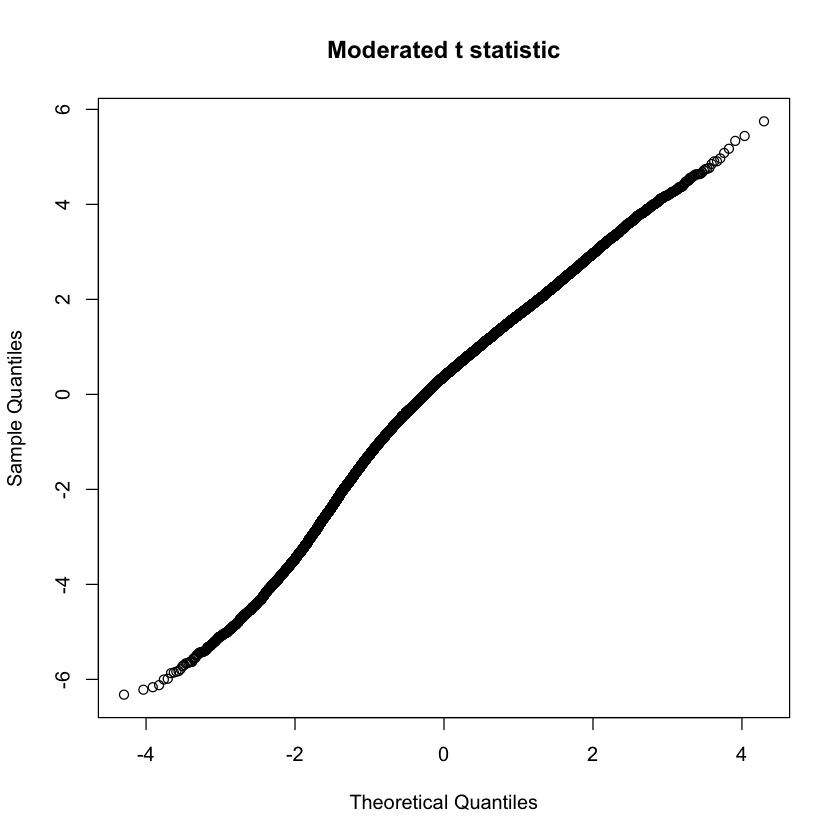

In [24]:
# create Q-Q plot for t-statistic
t.good <- which(!is.na(fit2$F)) # filter out bad probes
qqt(fit2$t[t.good], fit2$df.total[t.good], main="Moderated t statistic")

[1] "Control-AD"

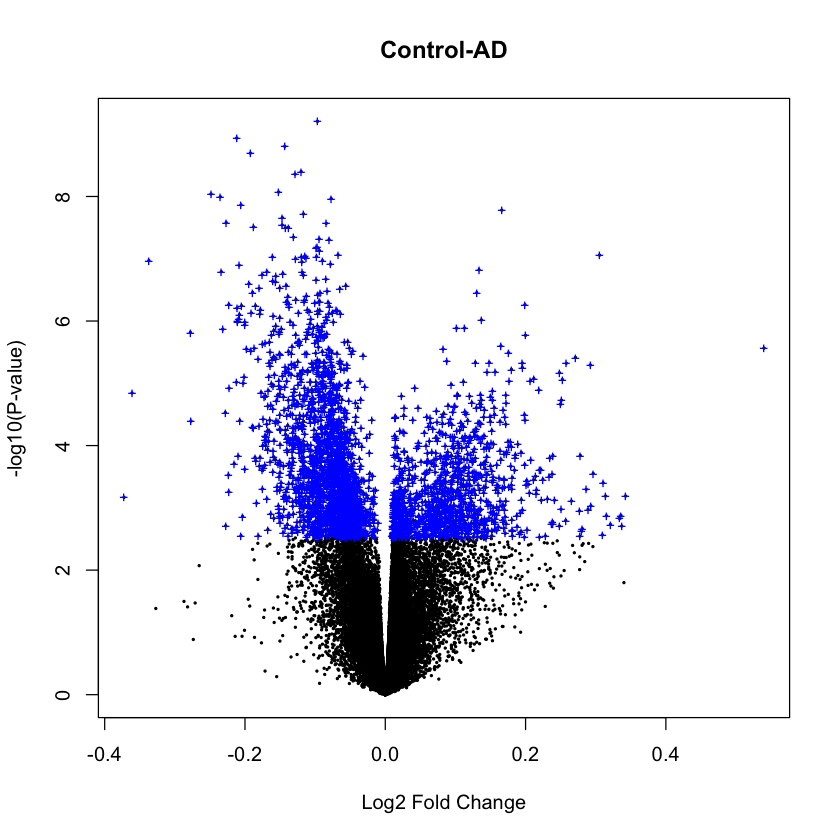

In [25]:
# volcano plot (log P-value vs log fold change)
colnames(fit2) # list contrast names
ct <- 1        # choose contrast of interest
# The following will produce basic volcano plot using limma function:
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(dT[,ct]!=0)), names=rep('+', nrow(fit2)))

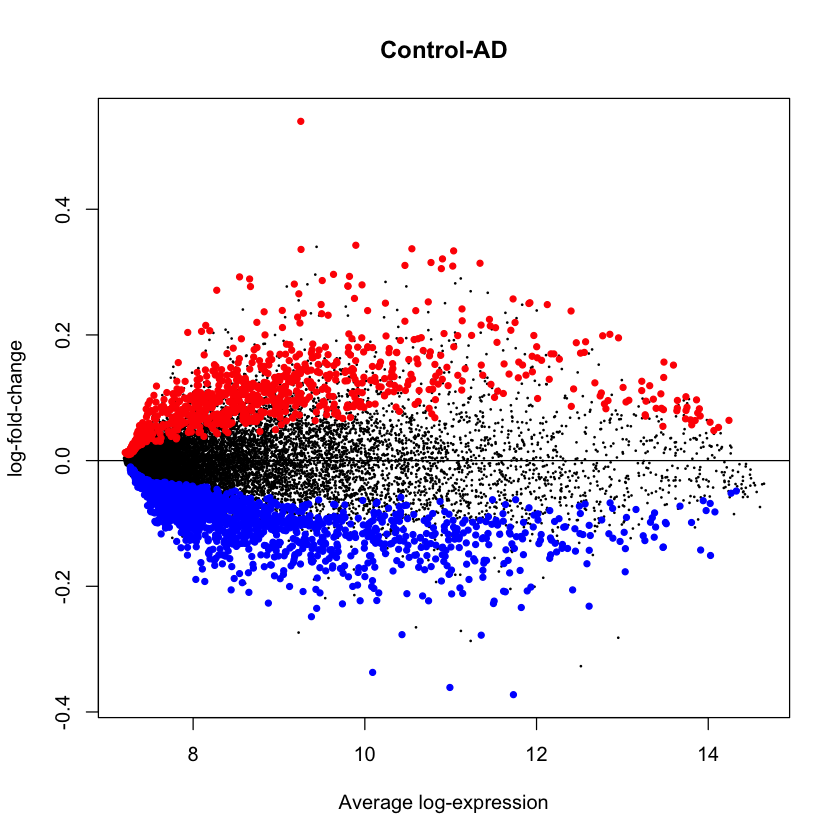

In [11]:
# MD plot (log fold change vs mean log expression)
# highlight statistically significant (p-adj < 0.05) probes
plotMD(fit2, column=ct, status=dT[,ct], legend=F, pch=20, cex=1)
abline(h=0)

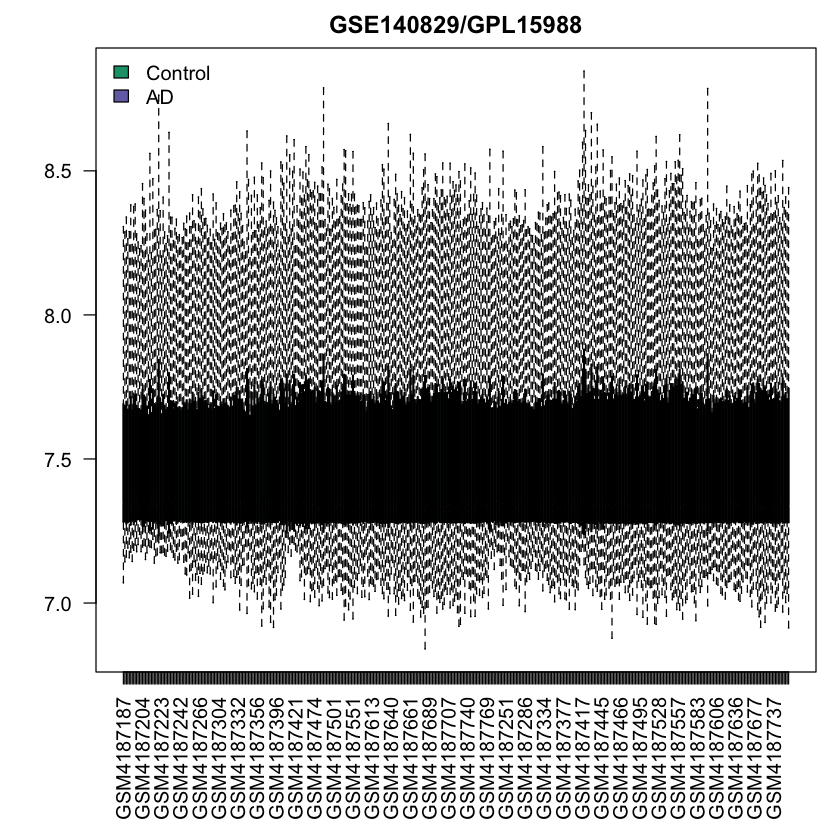

In [12]:
ex <- exprs(gset)
# box-and-whisker plot
ord <- order(gs)  # order samples by group
palette(c("#1B9E77", "#7570B3", "#E7298A", "#E6AB02", "#D95F02",
          "#66A61E", "#A6761D", "#B32424", "#B324B3", "#666666"))
par(mar=c(7,4,2,1))
title <- paste ("GSE140829", "/", annotation(gset), sep ="")
boxplot(ex[,ord], boxwex=0.6, notch=T, main=title, outline=FALSE, las=2, col=gs[ord])
legend("topleft", groups, fill=palette(), bty="n")


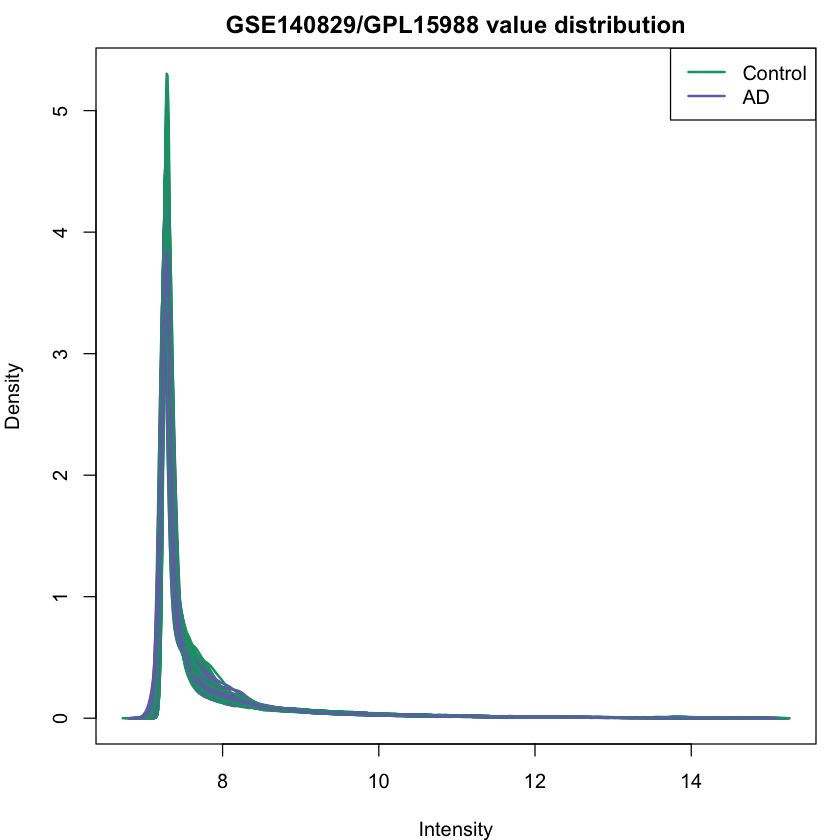

In [13]:
par(mar=c(4,4,2,1))
title <- paste ("GSE140829", "/", annotation(gset), " value distribution", sep ="")
plotDensities(ex, group=gs, main=title, legend ="topright")

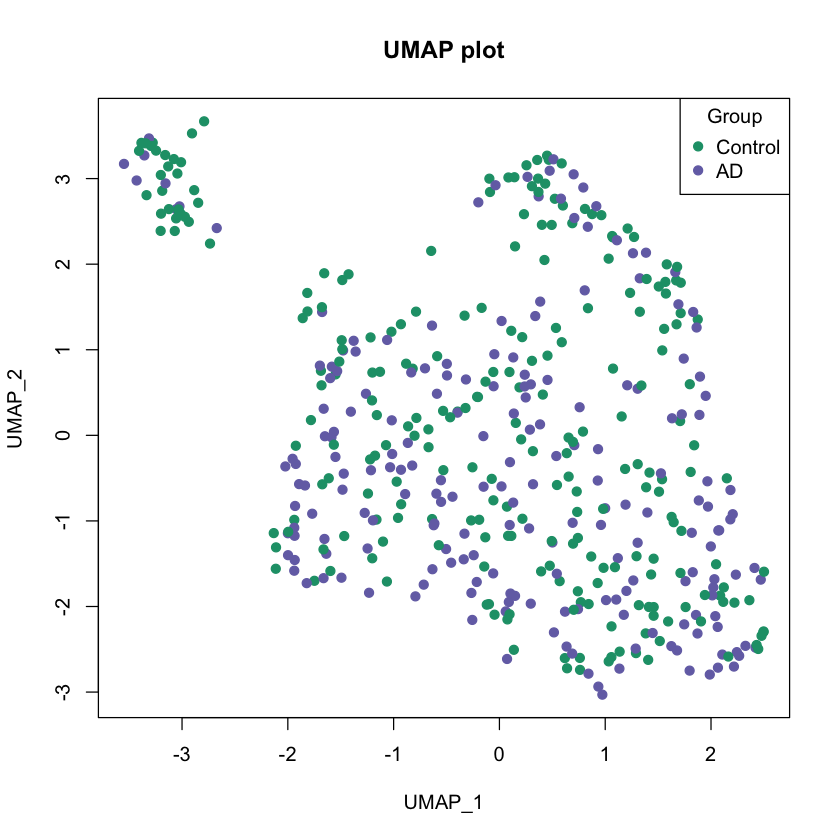

In [22]:
# UMAP plot (dimensionality reduction)
ex <- na.omit(ex) # eliminate rows with NAs
ex <- ex[!duplicated(ex), ]  # remove duplicates
ump <- umap(t(ex), n_neighbors = 50, random_state = 123)
plot(ump$layout, main="UMAP plot", xlab="UMAP_1", ylab="UMAP_2", col=gs, pch=20, cex=1.5)
legend("topright", legend=levels(gs), pch=20, col=1:nlevels(gs), title="Group", pt.cex=1.5)

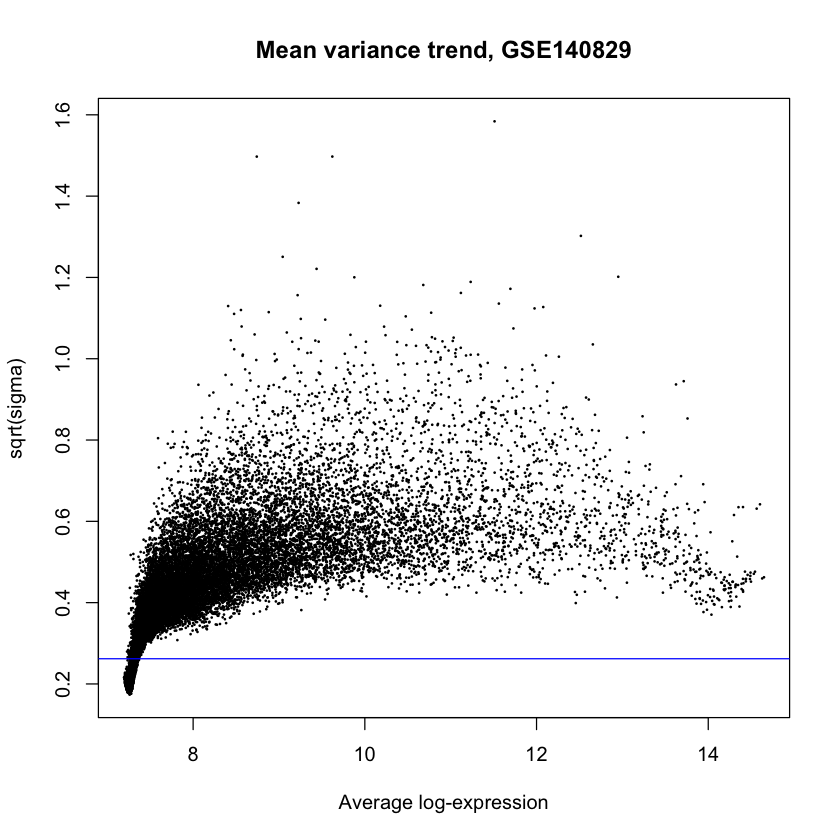

In [20]:
# mean-variance trend, helps to see if precision weights are needed
plotSA(fit2, main="Mean variance trend, GSE140829")

# KEGG and GSEA Analysis

In [21]:
BiocManager::install("clusterProfiler")
BiocManager::install("pathview")
BiocManager::install("enrichplot")
BiocManager::install("org.Hs.eg.db")
install.packages("dplyr")
install.packages("ggridges")
library(dplyr)
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(ggridges)
library("org.Hs.eg.db", character.only = TRUE)
library(pathview)
library(ggridges)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Installing package(s) 'clusterProfiler'

also installing the dependencies 'tweenr', 'systemfonts', 'blob', 'plogr', 'fastmatch', 'ggforce', 'tidygraph', 'graphlayouts', 'DBI', 'RSQLite', 'KEGGREST', 'HDO.db', 'fgsea', 'ggnewscale', 'ggraph', 'scatterpie', 'shadowtext', 'AnnotationDbi', 'downloader', 'DOSE', 'enrichplot', 'GO.db', 'GOSemSim', 'gson', 'qvalue'





The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpO13d7T/downloaded_packages


installing the source packages 'HDO.db', 'GO.db'


Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'fontawesome', 'later',
  'progressr', 'promises', 'reticulate', 'uwot'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Installing package(s) 'pathview'

also installing the dependencies 'KEGGgraph', 'XML', 'Rgraphviz', 'graph', 'org.Hs.eg.db'





The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpO13d7T/downloaded_packages


installing the source package 'org.Hs.eg.db'


Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'fontawesome', 'later',
  'progressr', 'promises', 'reticulate', 'uwot'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Warning message:
"package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'enrichplot'"
Old packages: 'RcppArmadillo', 'curl', 'dendextend', 'fontawesome', 'later',
  'progressr', 'promises', 'reticulate', 'uwot'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.25), R 4.3.3 (2024-02-29)

Warning message:
"package(s


The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpO13d7T/downloaded_packages

The downloaded binary packages are in
	/var/folders/2r/2m1p3nmd3m1235kf7dxs1cl40000gn/T//RtmpO13d7T/downloaded_packages



Attaching package: 'dplyr'


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors



# AD & Control

In [25]:
head(tT)

ID                 GB_ACC    GENE.SYMBOL
cfcaYCXlFUQ4NRXnUc cfcaYCXlFUQ4NRXnUc NM_014726 TBKBP1     
3UIToHu90KvO6pup3U 3UIToHu90KvO6pup3U NM_020531 C20orf3    
097eBEJe9y16aBEeqs 097eBEJe9y16aBEeqs NM_032569 GLYR1      
i.kl53LqElSJenlTTs i.kl53LqElSJenlTTs NM_182470 PKM2       
fkr9ClCeuFeeLbiaKA fkr9ClCeuFeeLbiaKA NM_024872 DOK3       
TUn0kjzm3hKBFVZ83Q TUn0kjzm3hKBFVZ83Q NM_001315 MAPK14     
                   GENE.DESCRIPTION                             logFC     
cfcaYCXlFUQ4NRXnUc TBK1 binding protein 1                       -0.0966419
3UIToHu90KvO6pup3U chromosome 20 open reading frame 3           -0.2117725
097eBEJe9y16aBEeqs glyoxylate reductase 1 homolog (Arabidopsis) -0.1433444
i.kl53LqElSJenlTTs pyruvate kinase, muscle                      -0.1923451
fkr9ClCeuFeeLbiaKA docking protein 3                            -0.1199759
TUn0kjzm3hKBFVZ83Q mitogen-activated protein kinase 14          -0.1286207
                   AveExpr   t         P.Value      adj.P.Val    B        
cfcaYCXlFUQ4NRXnUc  7.554578 -6.321547 6.213474e-10 2.367373e-05 11.772767
3UIToHu90KvO6pup3U 10.490023 -6.216969 1.152537e-09 2.367373e-05 11.170945
097eBEJe9y16aBEeqs  8.967478 -6.164506 1.566460e-09 2.367373e-05 10.872214
i.kl53LqElSJenlTTs  8.135821 -6.121235 2.014442e-09 2.367373e-05 10.627433
fkr9ClCeuFeeLbiaKA  7.940597 -6.002862 3.979494e-09 3.425889e-05  9.965285
TUn0kjzm3hKBFVZ83Q  7.808418 -5.986330 4.372731e-09 3.425889e-05  9.873684

In [26]:
organism = "org.Hs.eg.db"
original_gene_list <- as.numeric(tT$logFC)
names(original_gene_list) <- tT$GENE.SYMBOL


gene_list <- na.omit(original_gene_list)
gene_list <- gene_list[!is.na(names(gene_list))]

gene_df <- data.frame(gene = names(gene_list), score = gene_list)
gene_list_agg <- aggregate(score ~ gene, data = gene_df, FUN = mean)
gene_list <- setNames(gene_list_agg$score, gene_list_agg$gene)
gene_list <- sort(gene_list, decreasing = TRUE)

gse <- gseGO(geneList=gene_list,
             ont ="ALL",
             keyType = "SYMBOL",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 0.05,
             verbose = TRUE,
             OrgDb = organism,
             pAdjustMethod = "none")

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
"For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation."
leading edge analysis...

done...



Loading required package: DOSE

DOSE v3.28.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609




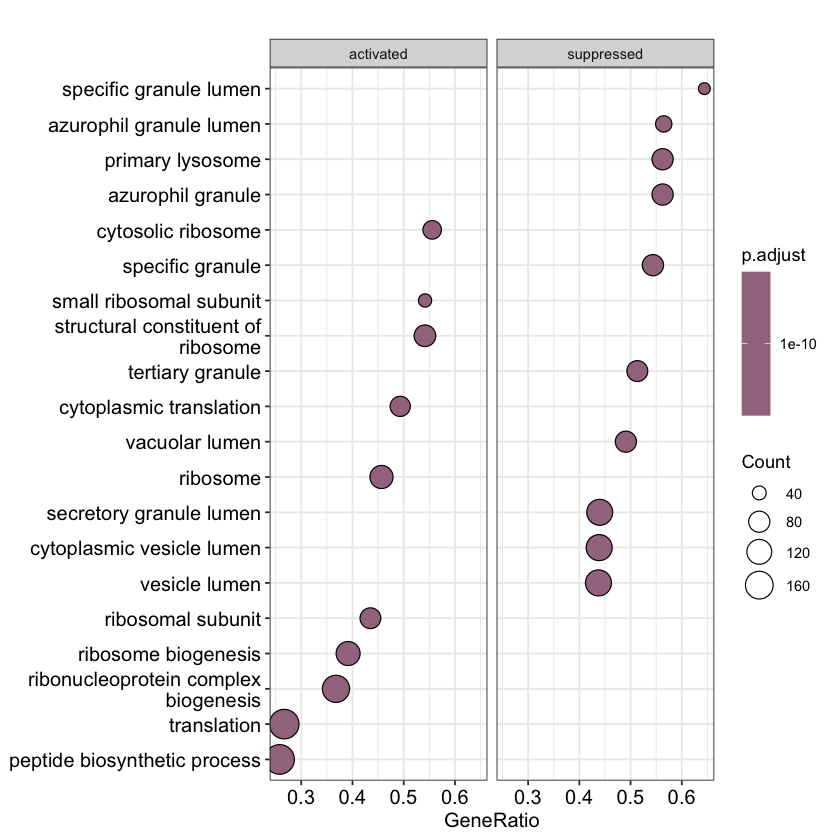

In [27]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)

In [29]:
gse <- pairwise_termsim(gse)
emapplot(gse, showCategory = 10)

ERROR while rich displaying an object: Error in `geom_edge_link()`:
! Problem while converting geom to grob.
i Error occurred in the 1st layer.
Caused by error:
! vector memory exhausted (limit reached?)

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .    

In [30]:
cnetplot(gse, categorySize="pvalue", foldChange=gene_list, showCategory = 3)

Warning message in cnetplot.enrichResult(x, ...):
"Use 'color.params = list(foldChange = your_value)' instead of 'foldChange'.
 The foldChange parameter will be removed in the next version."


ERROR while rich displaying an object: Error in `geom_edge()`:
! Problem while converting geom to grob.
i Error occurred in the 1st layer.
Caused by error:
! vector memory exhausted (limit reached?)

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (

Picking joint bandwidth of 0.0157



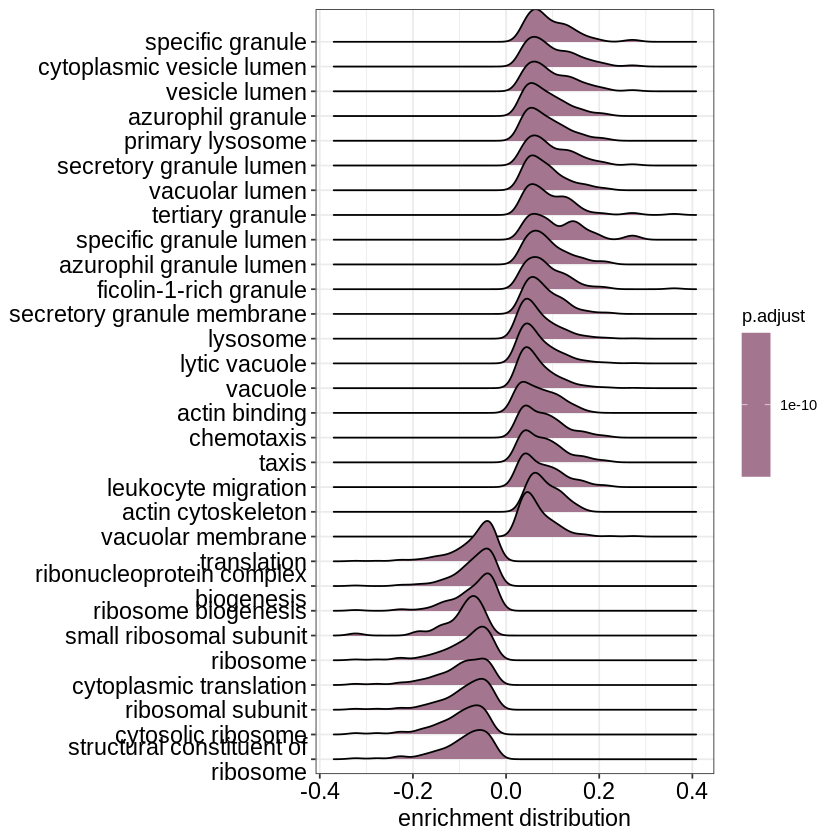

In [ ]:
ridgeplot(gse) + labs(x = "enrichment distribution")

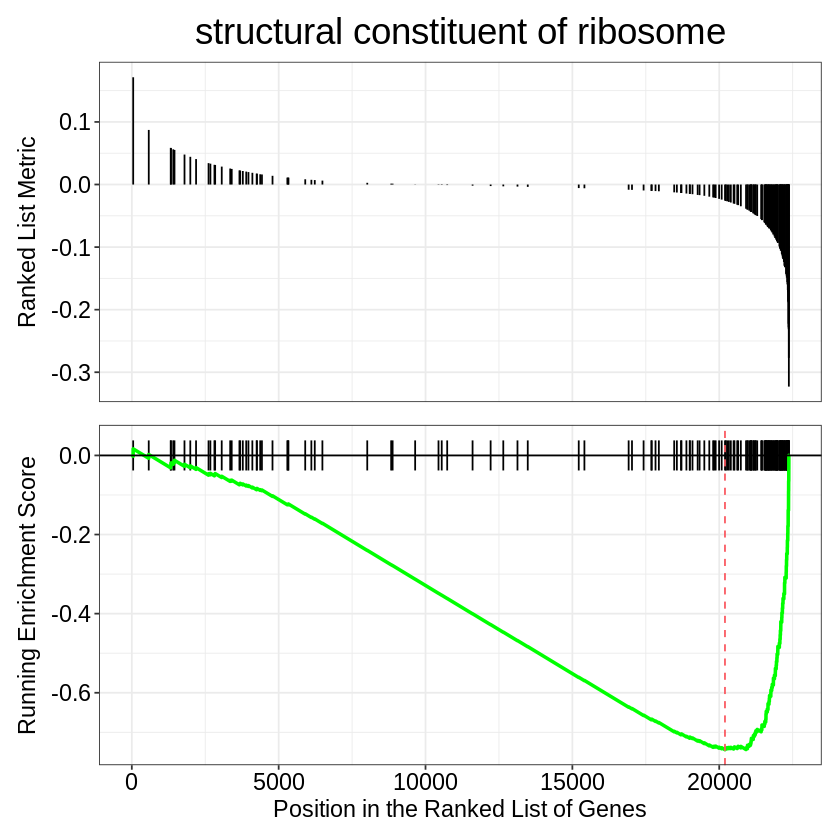

In [ ]:
gseaplot(gse, by = "all", title = gse$Description[1], geneSetID = 1)

In [ ]:
ids<-bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db")
dedup_ids = ids[!duplicated(ids[c("SYMBOL")]),]
tT_subset = tT[,c("GENE.SYMBOL", "AD.Control", "F", "P.Value", "adj.P.Val")]
combined_set <- merge(dedup_ids, tT_subset, by.x = "SYMBOL", by.y = "GENE.SYMBOL", all.x = TRUE)
clean_combined_set <- combined_set[!duplicated(combined_set), ]

clean_combined_set <- clean_combined_set %>%
  group_by(SYMBOL, ENTREZID) %>%
  summarize(
    AD.Control = mean(AD.Control, na.rm = TRUE),
    F = mean(F, na.rm = TRUE),
    P.Value = mean(P.Value, na.rm = TRUE),
    adj.P.Val = mean(adj.P.Val, na.rm = TRUE),
    .groups = "drop"  # Optional: to remove the grouping after summarizing
  )

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", :
“20.14% of input gene IDs are fail to map...”


In [ ]:
kegg_gene_list <- clean_combined_set$AD.Control
names(kegg_gene_list) <- clean_combined_set$ENTREZID
kegg_gene_list <- na.omit(kegg_gene_list)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

kegg_organism = "hsa"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               nPerm        = 10000,
               minGSSize    = 3,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               keyType       = "ncbi-geneid")

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Reading KEGG annotation online: "https://rest.kegg.jp/conv/ncbi-geneid/hsa"...

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
leading edge analysis...

done...



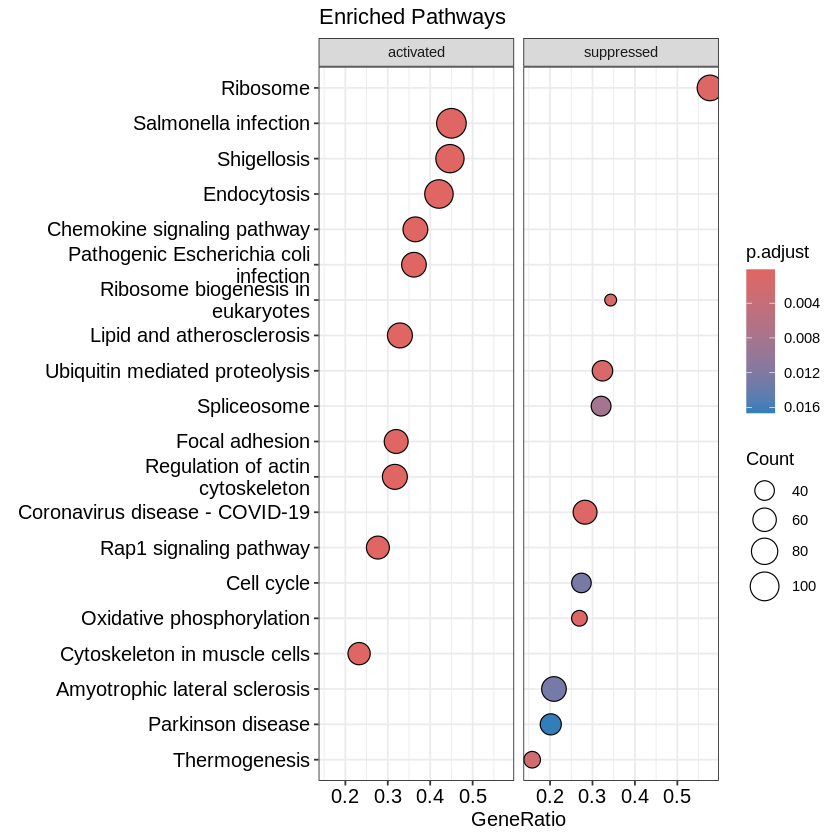

In [ ]:
dotplot(kk2, showCategory = 10, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

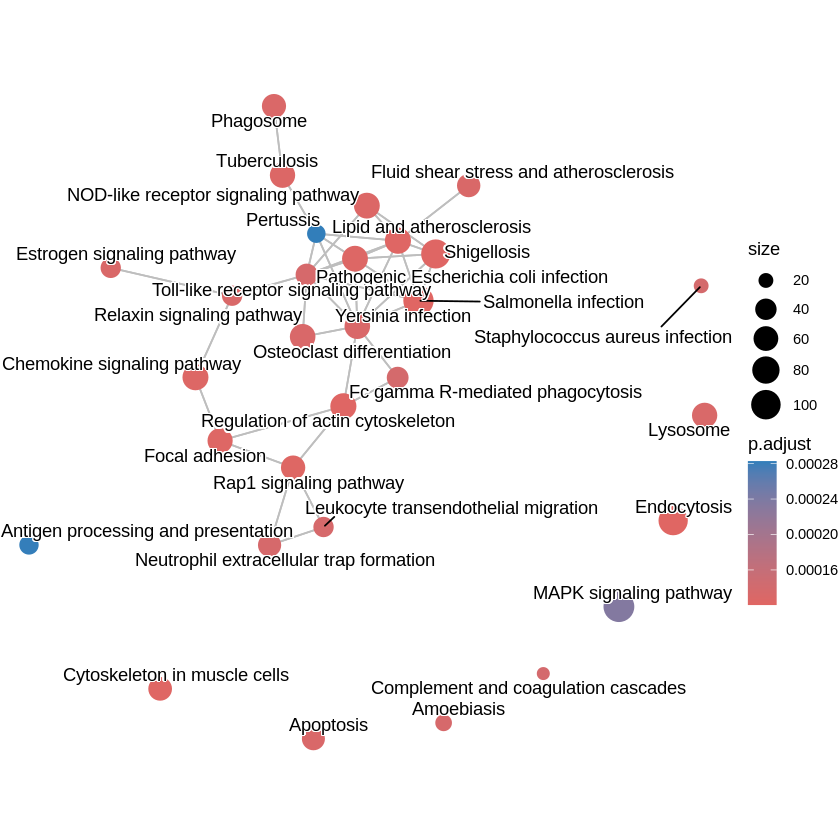

In [ ]:
kk2 <- pairwise_termsim(kk2)
emapplot(kk2)

Warning message:
“ggrepel: 39 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


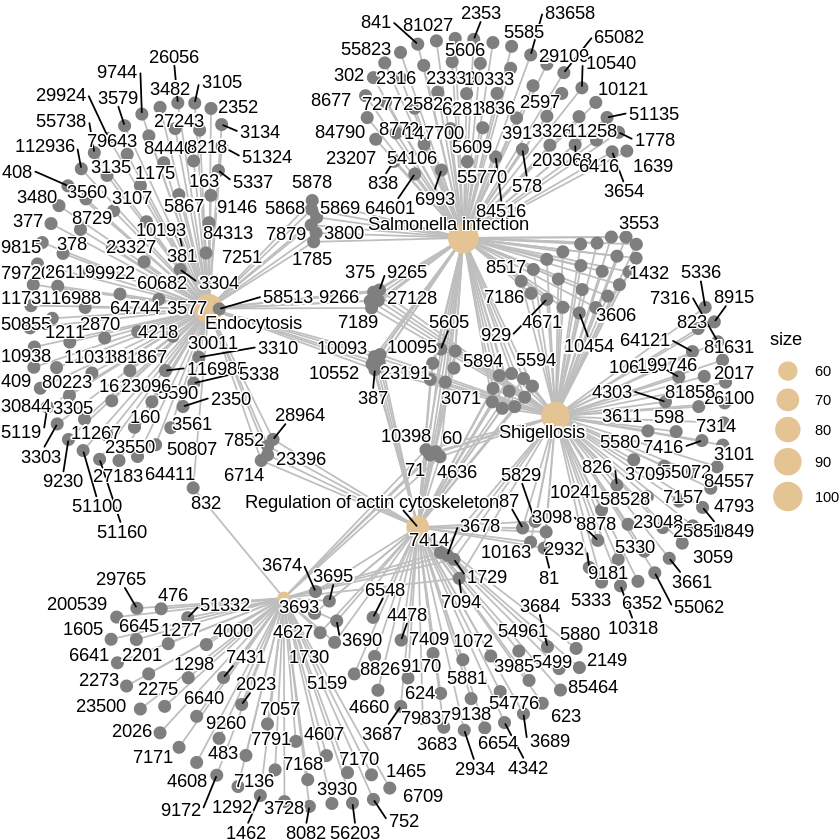

In [ ]:
cnetplot(kk2, categorySize="pvalue", foldChange=gene_list)

Picking joint bandwidth of 0.0153



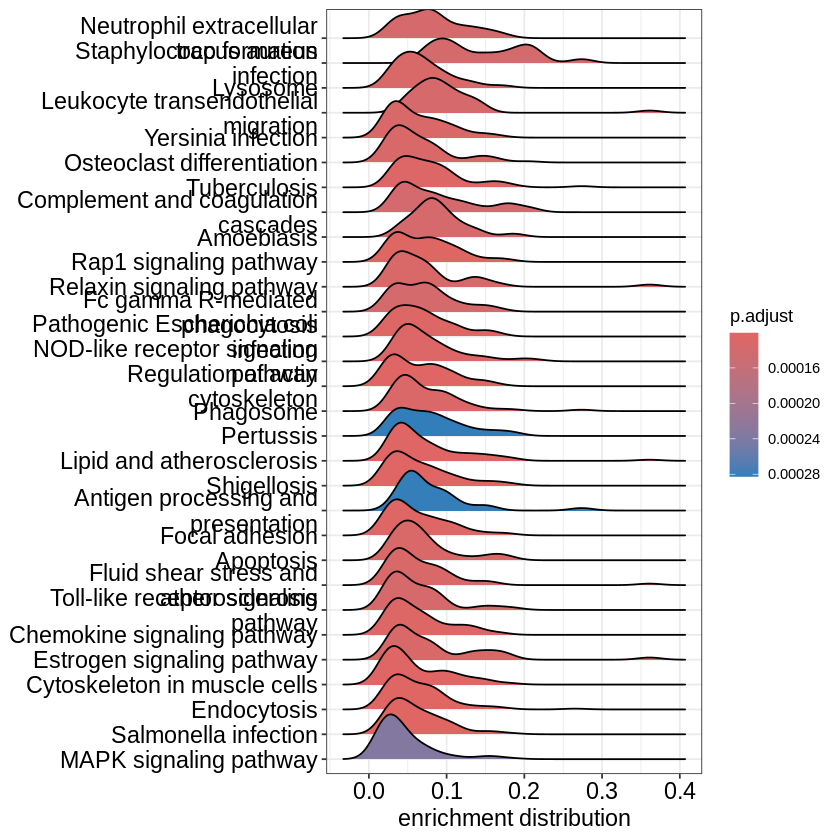

In [ ]:
ridgeplot(kk2) + labs(x = "enrichment distribution")

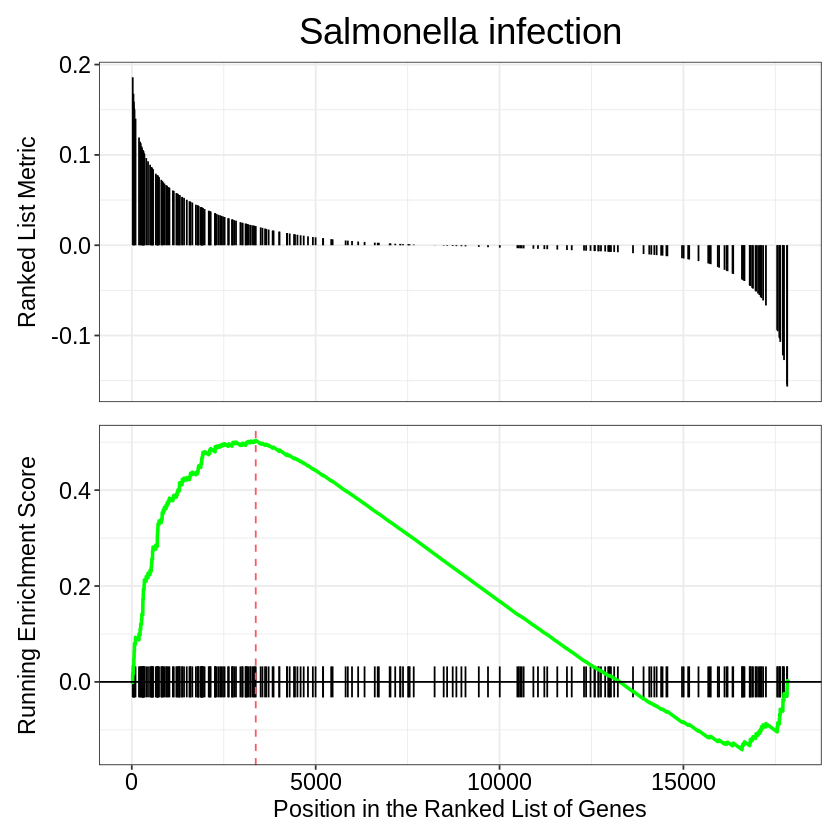

In [ ]:
gseaplot(kk2, by = "all", title = kk2$Description[1], geneSetID = 1)

In [ ]:
dme <- pathview(gene.data=kegg_gene_list, pathway.id="dme04130", species = kegg_organism)

Info: Downloading xml files for hsadme04130, 1/1 pathways..

Warning message in download.file(xml.url, xml.target, quiet = T):
“cannot open URL 'https://rest.kegg.jp/get/hsadme04130/kgml': HTTP status was '404 Not Found'”
This pathway may not exist!

Info: Downloading png files for hsadme04130, 1/1 pathways..

This pathway may not exist!




In [ ]:
organism = "org.Hs.eg.db"
original_gene_list <- as.numeric(tT$Control.MCI)
names(original_gene_list) <- tT$GENE.SYMBOL


gene_list <- na.omit(original_gene_list)
gene_list <- gene_list[!is.na(names(gene_list))]

gene_df <- data.frame(gene = names(gene_list), score = gene_list)
gene_list_agg <- aggregate(score ~ gene, data = gene_df, FUN = mean)
gene_list <- setNames(gene_list_agg$score, gene_list_agg$gene)
gene_list <- sort(gene_list, decreasing = TRUE)

gse <- gseGO(geneList=gene_list,
             ont ="ALL",
             keyType = "SYMBOL",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 0.05,
             verbose = TRUE,
             OrgDb = organism,
             pAdjustMethod = "none")

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



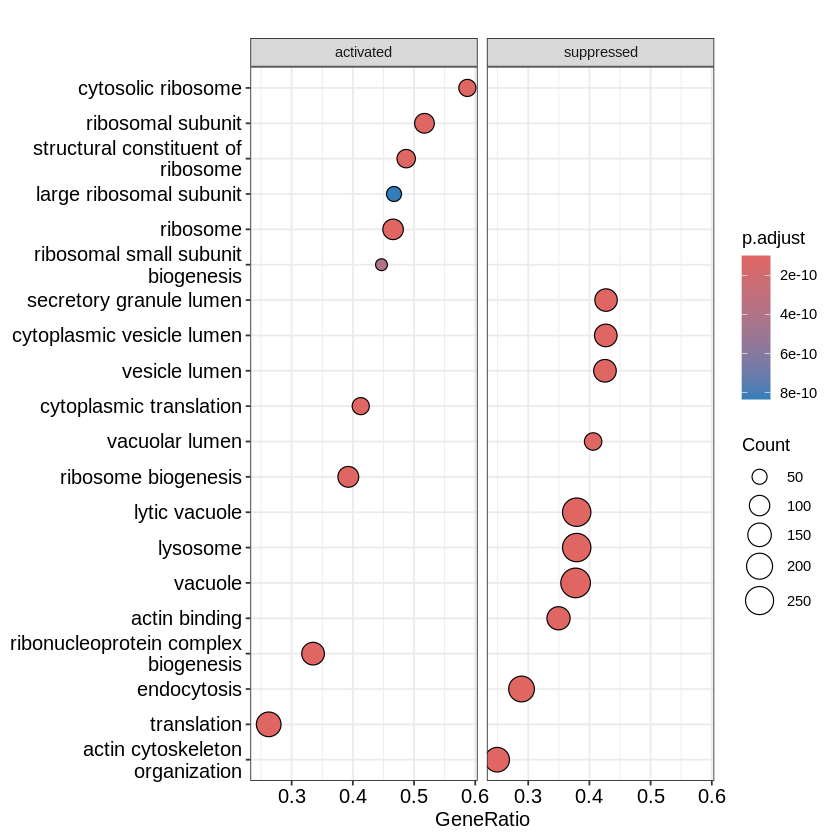

In [ ]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)

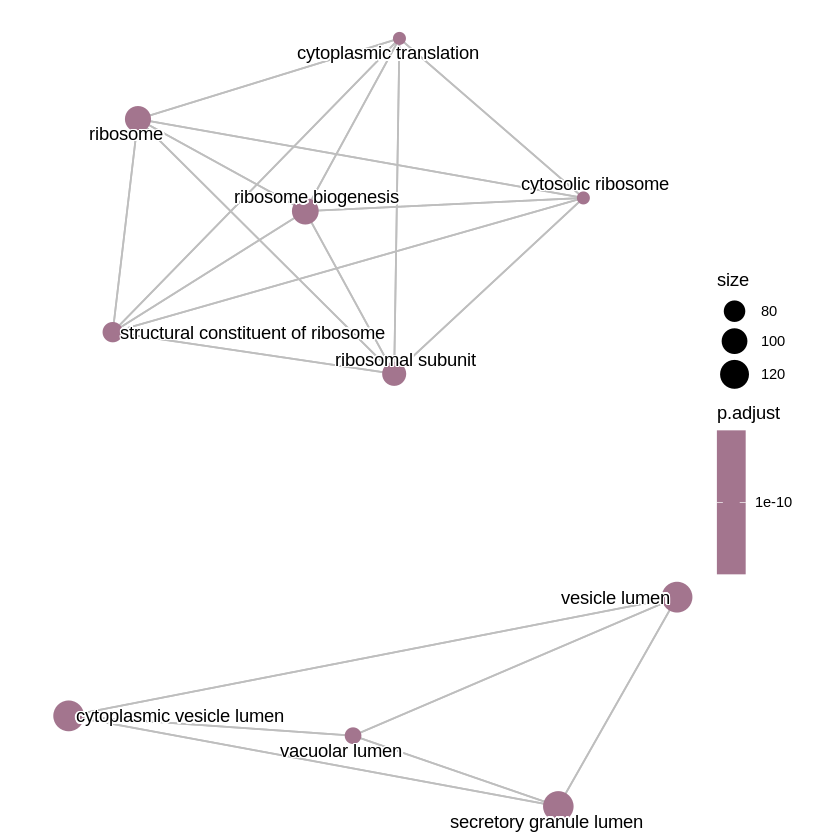

In [ ]:
gse <- pairwise_termsim(gse)
emapplot(gse, showCategory = 10)

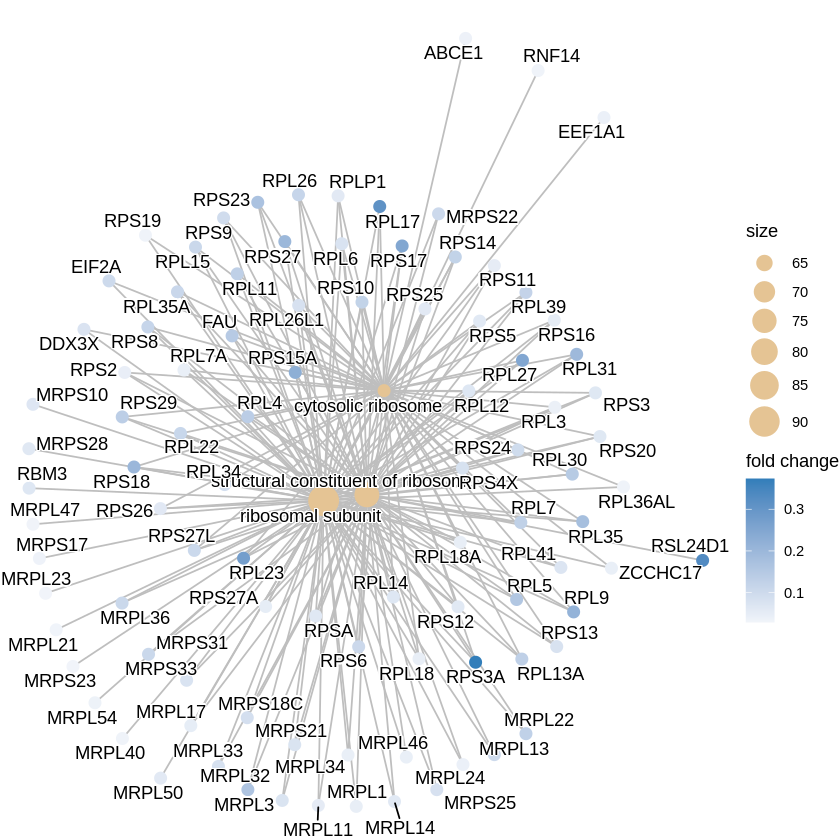

In [ ]:
cnetplot(gse, categorySize="pvalue", foldChange=gene_list, showCategory = 3)

Picking joint bandwidth of 0.0152



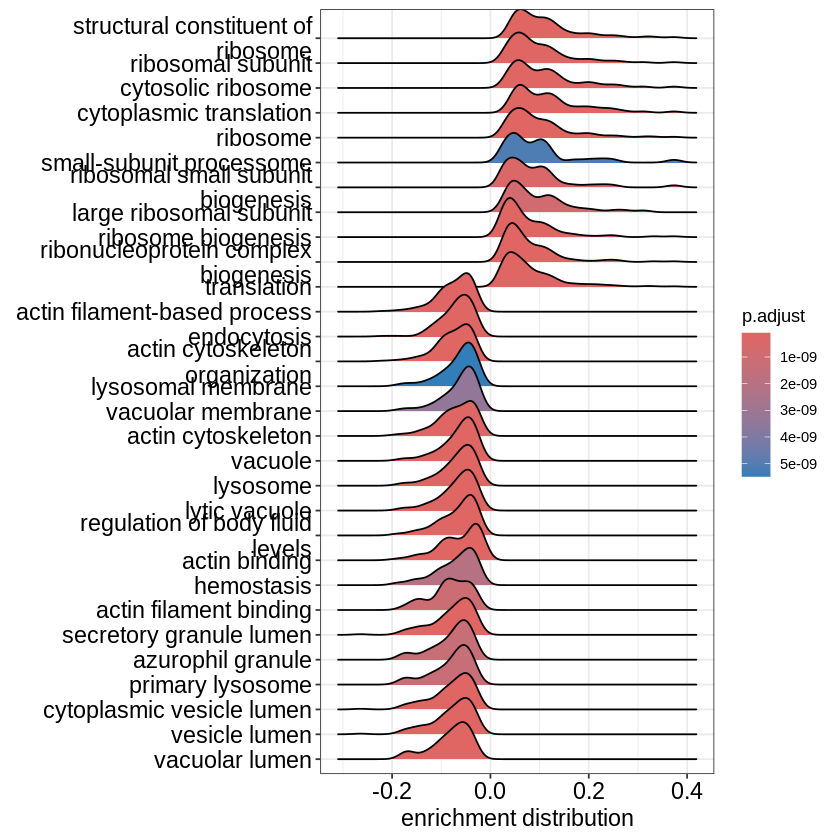

In [ ]:
ridgeplot(gse) + labs(x = "enrichment distribution")

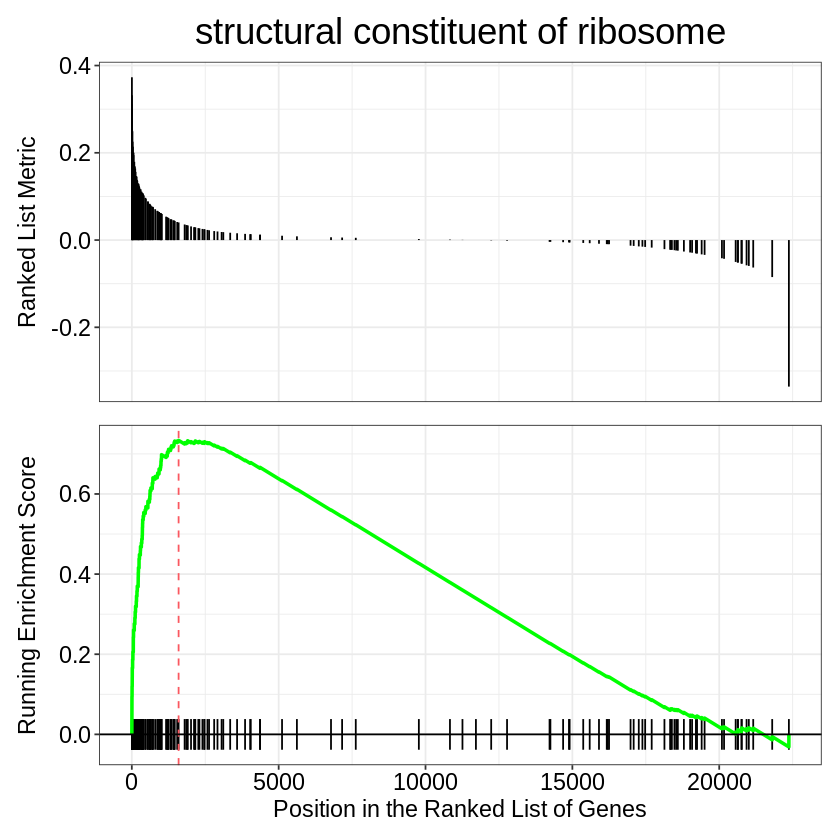

In [ ]:
gseaplot(gse, by = "all", title = gse$Description[1], geneSetID = 1)

In [ ]:
ids<-bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db")
dedup_ids = ids[!duplicated(ids[c("SYMBOL")]),]
tT_subset = tT[,c("GENE.SYMBOL", "AD.Control", "F", "P.Value", "adj.P.Val")]
combined_set <- merge(dedup_ids, tT_subset, by.x = "SYMBOL", by.y = "GENE.SYMBOL", all.x = TRUE)
clean_combined_set <- combined_set[!duplicated(combined_set), ]

clean_combined_set <- clean_combined_set %>%
  group_by(SYMBOL, ENTREZID) %>%
  summarize(
    AD.Control = mean(AD.Control, na.rm = TRUE),
    F = mean(F, na.rm = TRUE),
    P.Value = mean(P.Value, na.rm = TRUE),
    adj.P.Val = mean(adj.P.Val, na.rm = TRUE),
    .groups = "drop"  # Optional: to remove the grouping after summarizing
  )

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(names(original_gene_list), fromType = "SYMBOL", toType = "ENTREZID", :
“20.14% of input gene IDs are fail to map...”


In [ ]:
kegg_gene_list <- clean_combined_set$AD.Control
names(kegg_gene_list) <- clean_combined_set$ENTREZID
kegg_gene_list <- na.omit(kegg_gene_list)
kegg_gene_list = sort(kegg_gene_list, decreasing = TRUE)

kegg_organism = "hsa"
kk2 <- gseKEGG(geneList     = kegg_gene_list,
               organism     = kegg_organism,
               nPerm        = 10000,
               minGSSize    = 3,
               maxGSSize    = 800,
               pvalueCutoff = 0.05,
               pAdjustMethod = "none",
               keyType       = "ncbi-geneid")

using 'fgsea' for GSEA analysis, please cite Korotkevich et al (2019).


preparing geneSet collections...

GSEA analysis...

Warning message in .GSEA(geneList = geneList, exponent = exponent, minGSSize = minGSSize, :
“We do not recommend using nPerm parameter incurrent and future releases”
Warning message in fgsea(pathways = geneSets, stats = geneList, nperm = nPerm, minSize = minGSSize, :
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
leading edge analysis...

done...



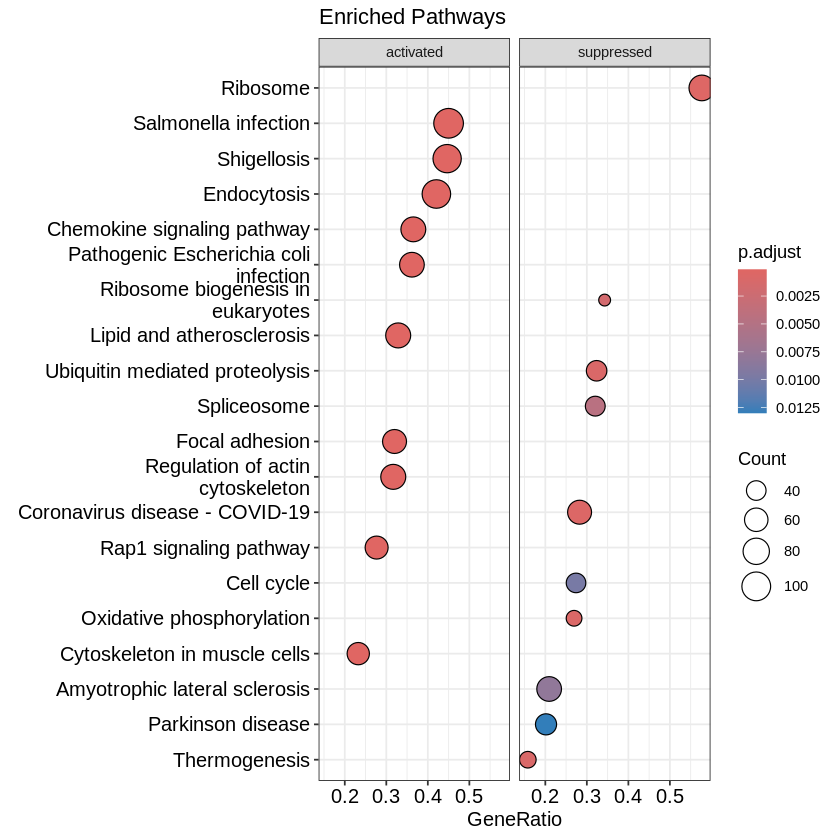

In [ ]:
dotplot(kk2, showCategory = 10, title = "Enriched Pathways" , split=".sign") + facet_grid(.~.sign)

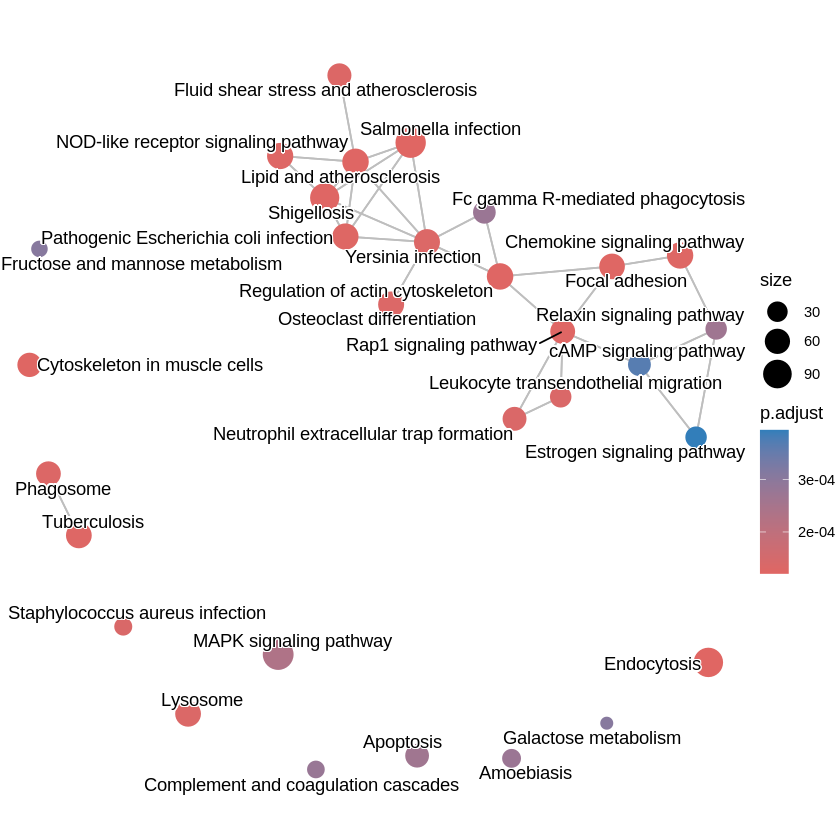

In [ ]:
kk2 <- pairwise_termsim(kk2)
emapplot(kk2)

Warning message:
“ggrepel: 44 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


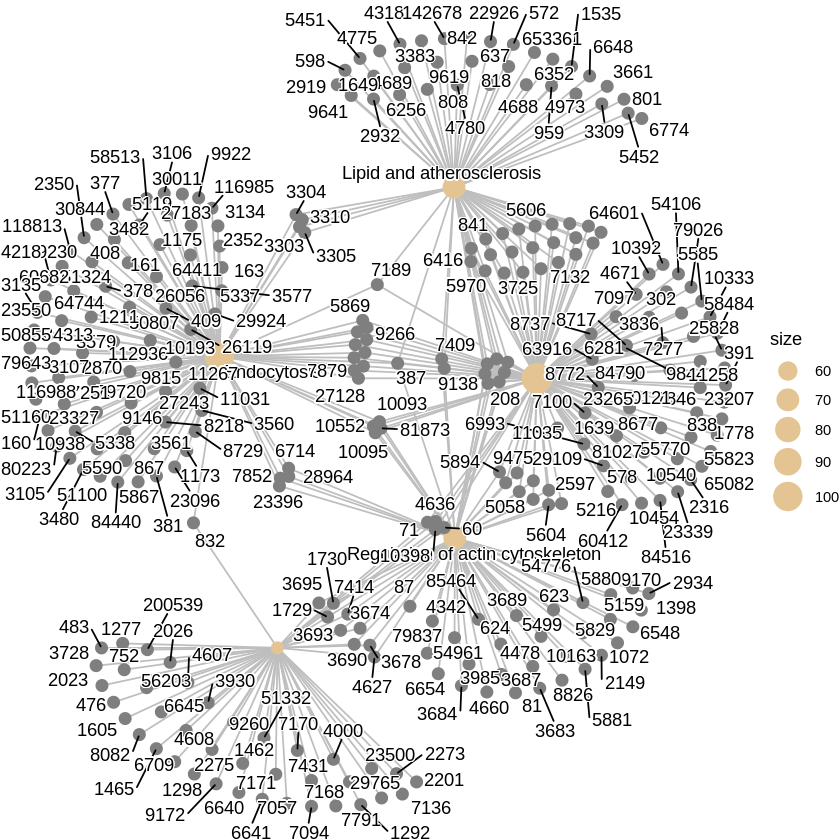

In [ ]:
cnetplot(kk2, categorySize="pvalue", foldChange=gene_list)

Picking joint bandwidth of 0.0152



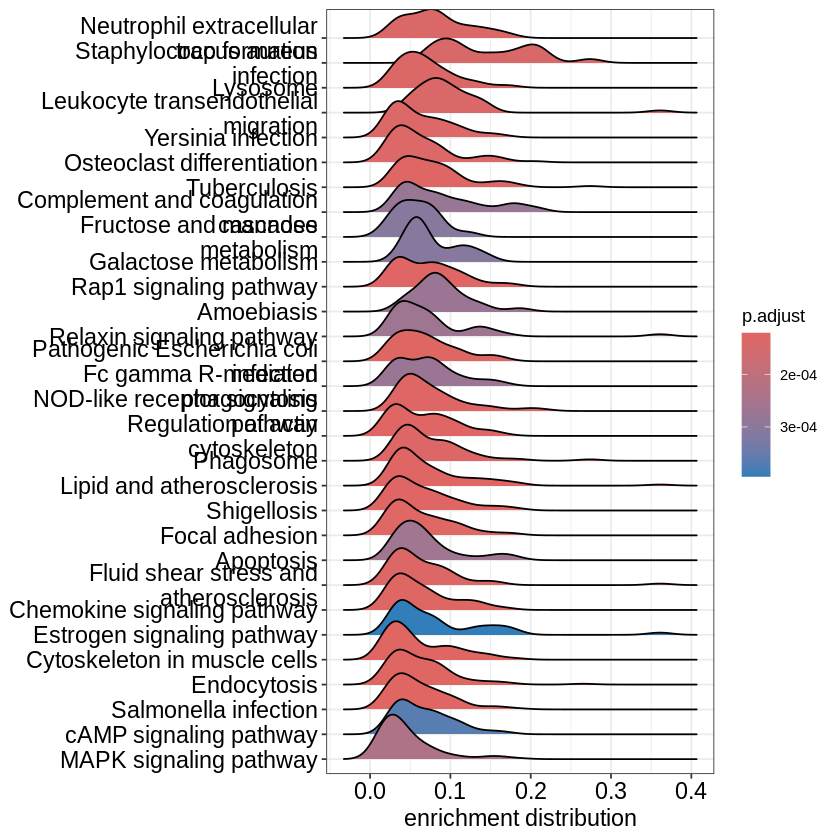

In [ ]:
ridgeplot(kk2) + labs(x = "enrichment distribution")

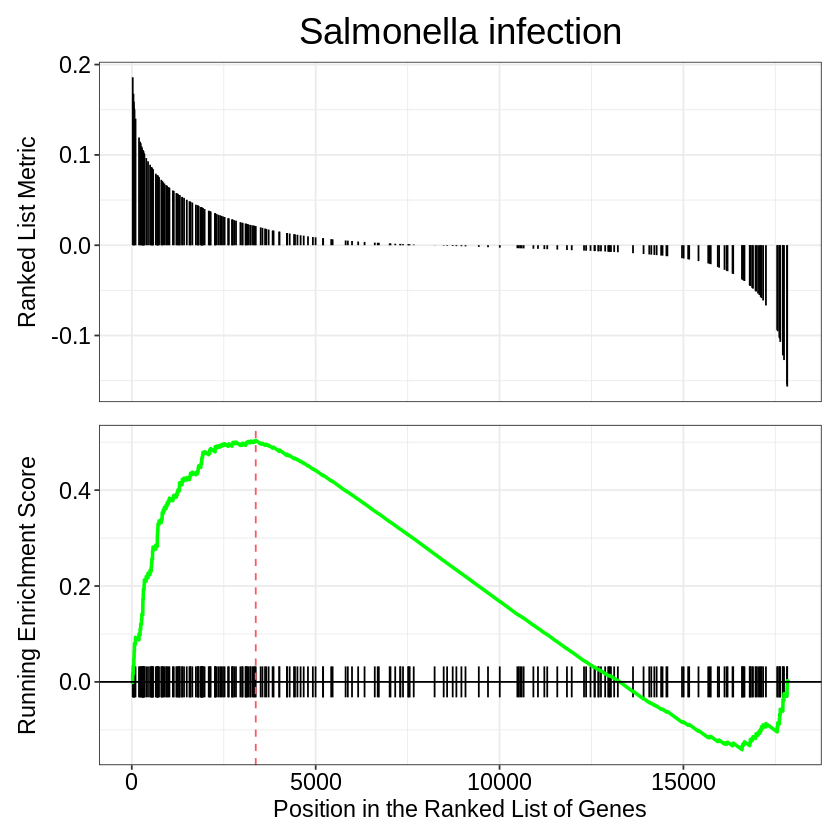

In [ ]:
gseaplot(kk2, by = "all", title = kk2$Description[1], geneSetID = 1)

In [ ]:
dme <- pathview(gene.data=kegg_gene_list, pathway.id="dme04130", species = kegg_organism)

Info: Downloading xml files for hsadme04130, 1/1 pathways..

Warning message in download.file(xml.url, xml.target, quiet = T):
“cannot open URL 'https://rest.kegg.jp/get/hsadme04130/kgml': HTTP status was '404 Not Found'”
This pathway may not exist!

Info: Downloading png files for hsadme04130, 1/1 pathways..

This pathway may not exist!


